In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense


### Data exploration 

In [172]:
data_path = '/Users/mirimichaeli/projects/nucleix/Bladder data for task.xlsx'
bladder_data = pd.read_excel(data_path)
bladder_data.head()


,Sample,Gold Standard,Sex,Age,ISL19614,ISL18938,ISL11482,ISL7550,ISL26637,ISL8677,ISL22730,ISL6568,ISL7803,ISL9258,ISL22274,ISL361,ISL1929,ISL2504,ISL10877
0,Am008,Negative,NaN,NaN,9.300,inf,12.603,12.435,10.521,8.930,8.781,11.849,8.910,9.900,8.643,12.631,11.046,10.143,13.305
1,AM010,Negative,M,61.0,7.832,18.668,12.121,11.681,11.238,9.017,10.970,17.179,11.412,10.391,8.580,15.324,12.594,11.615,14.771
2,AM014,Negative,F,84.0,8.487,16.073,inf,11.525,9.398,9.147,9.703,11.161,7.919,9.603,10.972,10.873,11.268,10.822,12.145
3,AM015,Negative,M,66.0,8.516,inf,13.493,12.405,9.194,10.755,10.835,12.382,10.123,10.794,9.790,inf,11.997,13.039,12.432
4,AM016,Negative,M,62.0,7.273,13.081,inf,11.439,9.581,7.088,9.616,10.901,7.931,8.468,8.067,10.321,10.673,8.696,9.773


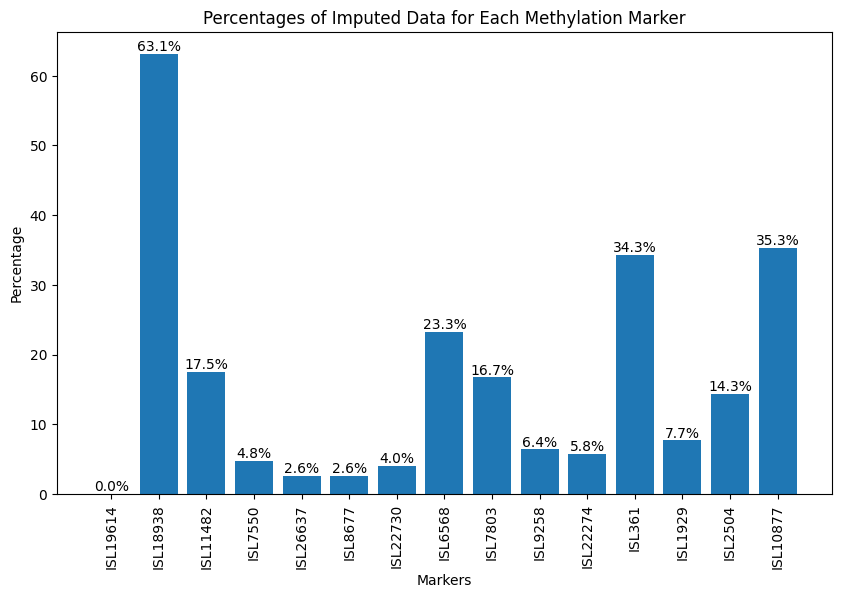

In [184]:
# Count how many imputed values - no methylation was detected
feature_columns = [col for col in bladder_data.columns if col.startswith('ISL')]

inf_count = np.isinf(bladder_data[feature_columns]).sum().sum()
inf_count # 3862 out of 24285 cells

imputed_dict = {}
for col in feature_columns:
    imputed = np.isinf(bladder_data[col]).sum().sum()
    imputed_percent = 100 * imputed / len(bladder_data[col])
    # print(f'{col} has {imputed} imputed values, being {imputed_percent} percent.')
    imputed_dict[col] = imputed_percent

imputed_df = pd.DataFrame({'Marker' : imputed_dict.keys(),
                           'Percent imputed' : imputed_dict.values()})

# Plot the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(imputed_df['Marker'], imputed_df['Percent imputed'])
plt.xlabel('Markers')
plt.ylabel('Percentage')
plt.title('Percentages of Imputed Data for Each Methylation Marker')
plt.xticks(rotation=90)

# Add percentage labels to each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')
plt.show()

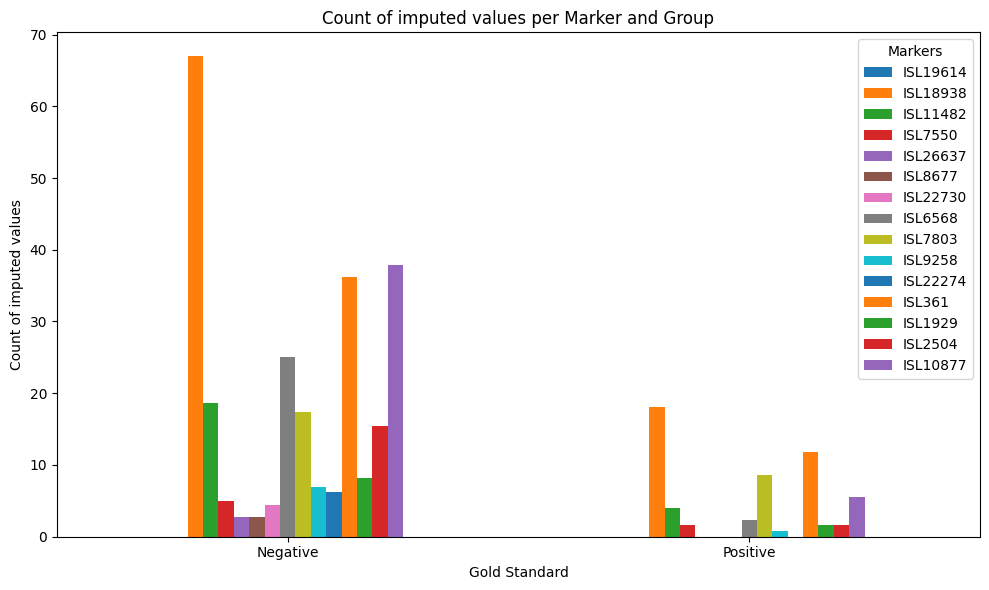

In [188]:
# Calculate the count of 'inf' values per marker and group
inf_counts = bladder_data.groupby('Gold Standard')[feature_columns].apply(lambda x: 100*np.isinf(x).sum()/len(x))
# note: here percentages are calculated from the total of each group, not the total of 1619 samples.

# Plotting
inf_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Gold Standard')
plt.ylabel('Count of imputed values')
plt.title('Count of imputed values per Marker and Group')
plt.legend(title='Markers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [189]:
inf_counts

,ISL19614,ISL18938,ISL11482,ISL7550,ISL26637,ISL8677,ISL22730,ISL6568,ISL7803,ISL9258,ISL22274,ISL361,ISL1929,ISL2504,ISL10877
Gold Standard,,,,,,,,,,,,,,,
Negative,0.0,66.957105,18.632708,5.026810,2.815013,2.815013,4.356568,25.067024,17.426273,6.903485,6.300268,36.260054,8.243968,15.415550,37.868633
Positive,0.0,18.110236,3.937008,1.574803,0.000000,0.000000,0.000000,2.362205,8.661417,0.787402,0.000000,11.811024,1.574803,1.574803,5.511811


In [29]:
# Impute data according to the comment that Infinity values (reflecting no methylation was detected) can be changed
# to a large number, e.g., 18:
bladder_data.replace(np.inf, 18, inplace=True)
# TODO for later clarification:
# what does it mean a negative value of a methylation marker?
# imputation was suggested to 18, while there are values in some markers that are >20, is 18 still ok for the imputation?
bladder_data.describe()

,Age,ISL19614,ISL18938,ISL11482,ISL7550,ISL26637,ISL8677,ISL22730,ISL6568,ISL7803,ISL9258,ISL22274,ISL361,ISL1929,ISL2504,ISL10877
count,773.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000
mean,70.917206,8.381935,16.396413,12.863351,11.577298,9.811849,8.944977,9.857766,13.306786,11.094128,9.930255,9.134477,14.556477,11.293637,11.196287,13.674042
std,10.677363,1.370882,2.925893,3.624704,2.505735,2.426723,2.830327,2.825918,3.943637,3.890307,3.342107,3.555448,3.519100,3.204055,3.921688,4.334200
min,38.000000,2.686000,4.835000,-0.349000,0.995000,-0.259000,-0.272000,1.639000,-0.411000,-0.442000,-0.298000,-1.642000,2.813000,0.023000,1.220000,-1.110000
25%,64.000000,7.766500,15.429000,10.584000,10.532000,8.689500,7.631500,8.457000,10.594500,8.722500,8.118000,7.234500,12.048500,9.405000,8.868500,10.638000
50%,71.000000,8.528000,18.000000,12.595000,11.643000,9.919000,8.908000,9.831000,13.106000,10.399000,9.652000,9.121000,14.799000,11.067000,10.844000,14.120000
75%,78.000000,9.190500,18.000000,15.413500,12.700500,10.900000,10.204500,11.134500,18.000000,12.576000,11.287000,10.770000,18.000000,13.028500,13.095500,18.000000
max,106.000000,16.057000,22.154000,21.843000,21.810000,22.899000,21.861000,19.496000,22.886000,20.507000,23.604000,18.000000,24.242000,21.227000,21.336000,23.288000


In [10]:
cancer_group = bladder_data[bladder_data['Gold Standard'] == 'Positive']
control_group = bladder_data[bladder_data['Gold Standard'] == 'Negative']
cancer_group.describe()

,Age,ISL19614,ISL18938,ISL11482,ISL7550,ISL26637,ISL8677,ISL22730,ISL6568,ISL7803,ISL9258,ISL22274,ISL361,ISL1929,ISL2504,ISL10877
count,54.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,71.740741,6.815567,12.787457,9.046551,8.803205,6.987748,5.669181,6.533291,9.177874,9.097748,6.628543,4.601850,10.952449,7.840126,6.816276,7.891071
std,11.970380,1.847611,3.918640,3.925243,2.725560,2.310164,2.524605,2.499190,3.684558,4.540938,3.372947,2.826203,4.224466,3.047220,3.557882,4.117215
min,42.000000,2.686000,5.579000,2.097000,3.979000,2.759000,1.295000,1.873000,2.412000,-0.442000,1.339000,0.062000,3.544000,2.966000,2.347000,1.915000
25%,65.250000,5.336500,9.815500,5.883000,6.570000,4.949000,3.852500,4.669500,6.660000,6.797000,3.958500,2.129000,7.446000,5.522500,4.073000,4.602000
50%,74.000000,7.020000,12.421000,8.512000,8.223000,6.988000,4.958000,6.196000,8.669000,9.450000,5.993000,4.245000,10.423000,7.376000,6.439000,7.317000
75%,80.000000,8.342500,16.507500,11.908500,10.908000,8.662500,7.224500,8.412000,11.075500,11.711500,8.674000,6.133500,14.256000,9.684000,8.641000,9.856500
max,91.000000,11.040000,21.262000,20.219000,18.000000,12.970000,13.250000,13.185000,20.226000,18.000000,20.020000,16.563000,23.597000,18.000000,18.061000,19.743000


In [11]:
control_group.describe()

,Age,ISL19614,ISL18938,ISL11482,ISL7550,ISL26637,ISL8677,ISL22730,ISL6568,ISL7803,ISL9258,ISL22274,ISL361,ISL1929,ISL2504,ISL10877
count,719.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000
mean,70.855355,8.515265,16.703609,13.188239,11.813430,10.052239,9.223815,10.140747,13.658241,11.264061,10.211299,9.520298,14.863255,11.587603,11.569117,14.166292
std,10.580567,1.234561,2.605483,3.407206,2.339754,2.280883,2.676311,2.667709,3.762181,3.783212,3.186234,3.338272,3.275705,3.041931,3.721118,3.982689
min,38.000000,3.305000,4.835000,-0.349000,0.995000,-0.259000,-0.272000,1.639000,-0.411000,0.340000,-0.298000,-1.642000,2.813000,0.023000,1.220000,-1.110000
25%,64.000000,7.881250,16.556250,10.919250,10.731750,9.007000,7.870750,8.692500,10.948250,8.909250,8.367500,7.686750,12.438500,9.735000,9.217750,11.318000
50%,71.000000,8.575500,18.000000,12.807500,11.758000,10.024500,9.054500,9.997000,13.454500,10.447000,9.816500,9.309000,15.069000,11.260500,11.062500,14.623000
75%,78.000000,9.224500,18.000000,15.916750,12.789500,10.961500,10.283250,11.229000,18.000000,12.676500,11.398500,10.935500,18.000000,13.150250,13.293750,18.000000
max,106.000000,16.057000,22.154000,21.843000,21.810000,22.899000,21.861000,19.496000,22.886000,20.507000,23.604000,18.000000,24.242000,21.227000,21.336000,23.288000


### Visualization

##### Gender distribution of healthy and sick groups

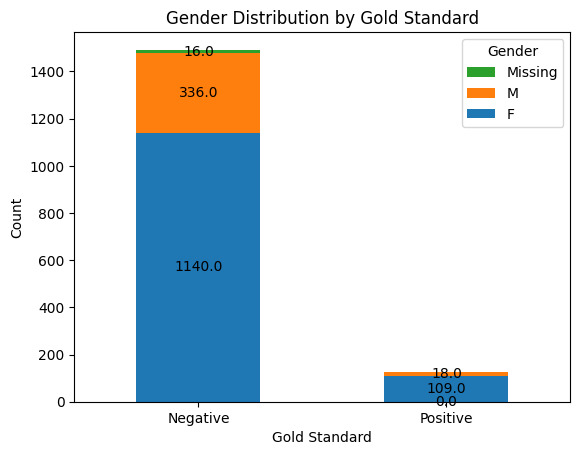

In [156]:
# Replace missing values with a string indicating 'Missing'
bladder_data['Sex'].fillna('Missing', inplace=True)

# Count the number of samples by gender and label
gender_counts = bladder_data.groupby(['Gold Standard', 'Sex']).size().unstack(fill_value=0)

# Create a bar chart
ax = gender_counts.plot(kind='bar', stacked=True)

# Get the unique gender categories (including 'Missing')
gender_categories = bladder_data['Sex'].unique().tolist()

# Get the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# Sort the handles and labels based on the order of gender_categories
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: gender_categories.index(x[1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Update the legend with the sorted handles and labels
ax.legend(sorted_handles, sorted_labels, title='Gender')

# Add labels indicating the count of samples in each part of the bars
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_y() + patch.get_height() / 2
    count = patch.get_height()
    ax.text(x, y, count, ha='center', va='center')

# Rotate x-axis labels horizontally
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.xlabel('Gold Standard')
plt.ylabel('Count')
plt.title('Gender Distribution by Gold Standard')
plt.show()

# note: biased data towards female samples. This imbalance may affect the prediction if gender has any relationship with the markers,
# this issue has to be further investigated as for the marker score dependency of gender.


#### Age distribution of healthy and sick

846


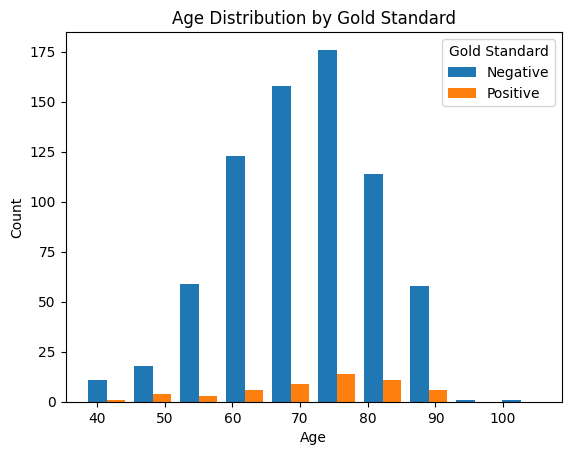

In [193]:
# Count how many missing values
print(np.isnan(bladder_data['Age']).sum().sum())

# Create a histogram for age distribution
plt.hist([bladder_data[bladder_data['Gold Standard'] == 'Negative']['Age'], bladder_data[bladder_data['Gold Standard'] == 'Positive']['Age']],
         bins=10, stacked=False, label=['Negative', 'Positive'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution by Gold Standard')
plt.legend(title='Gold Standard')
plt.show()

# note: normal distribution of age in both groups, kind of similar relative representation for each age group.
# note: 846 missing age

#### Distribution of marker values by healthy and sick

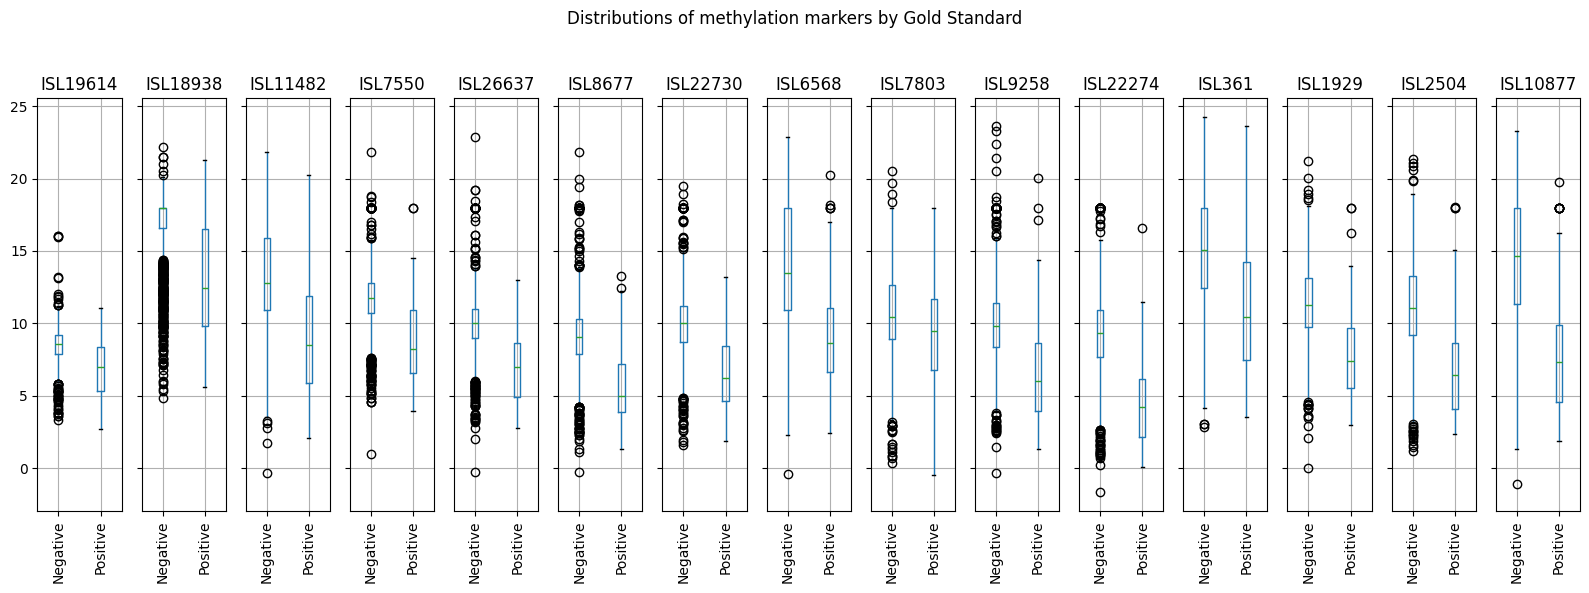

In [147]:
# Extract the feature columns starting with 'ISL'
feature_columns = [col for col in bladder_data.columns if col.startswith('ISL')]

# Create a box plot for each feature
fig, axes = plt.subplots(nrows=1, ncols=len(feature_columns), figsize=(16, 6), sharey=True)

for i, feature in enumerate(feature_columns):
    ax = axes[i]
    bladder_data.boxplot(column=feature, by='Gold Standard', ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('')
    # ax.set_ylabel(f'{feature} value')
    # Rotate x-axis labels by 90 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle('Distributions of methylation markers by Gold Standard')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# note: needs a statistical validation of the significance but some markers show difference

In [50]:
# Mann Whitney test for each feature:

# Sample data (replace with your actual data)
positive_data = bladder_data[bladder_data['Gold Standard'] == 'Positive']
negative_data = bladder_data[bladder_data['Gold Standard'] == 'Negative']

for feature in feature_columns:
    positive_values = positive_data[feature]
    negative_values = negative_data[feature]

    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(positive_values, negative_values, alternative='two-sided')

    print(f"Feature: {feature}, P-value: {p_value}")

# note: all methylation markers have significantly different distributions, although not all the markers show this separation by eye 
# (possibly a matter of sample sizes). 
    

Feature: ISL19614, P-value: 1.5622091924957413e-24
Feature: ISL18938, P-value: 8.006943708636848e-34
Feature: ISL11482, P-value: 1.4820647564044292e-27
Feature: ISL7550, P-value: 2.228976474869578e-30
Feature: ISL26637, P-value: 4.345855481713671e-37
Feature: ISL8677, P-value: 5.895336775354825e-38
Feature: ISL22730, P-value: 3.412820125946231e-38
Feature: ISL6568, P-value: 3.812514637681916e-30
Feature: ISL7803, P-value: 2.507071581690007e-06
Feature: ISL9258, P-value: 8.61511192204272e-30
Feature: ISL22274, P-value: 8.678524662783413e-46
Feature: ISL361, P-value: 4.918371186530877e-24
Feature: ISL1929, P-value: 1.4262307534735025e-32
Feature: ISL2504, P-value: 2.7876452368497035e-35
Feature: ISL10877, P-value: 2.7819423790021457e-42


#### Heatmap of the methylation features - check for dependencies/correlations between markers

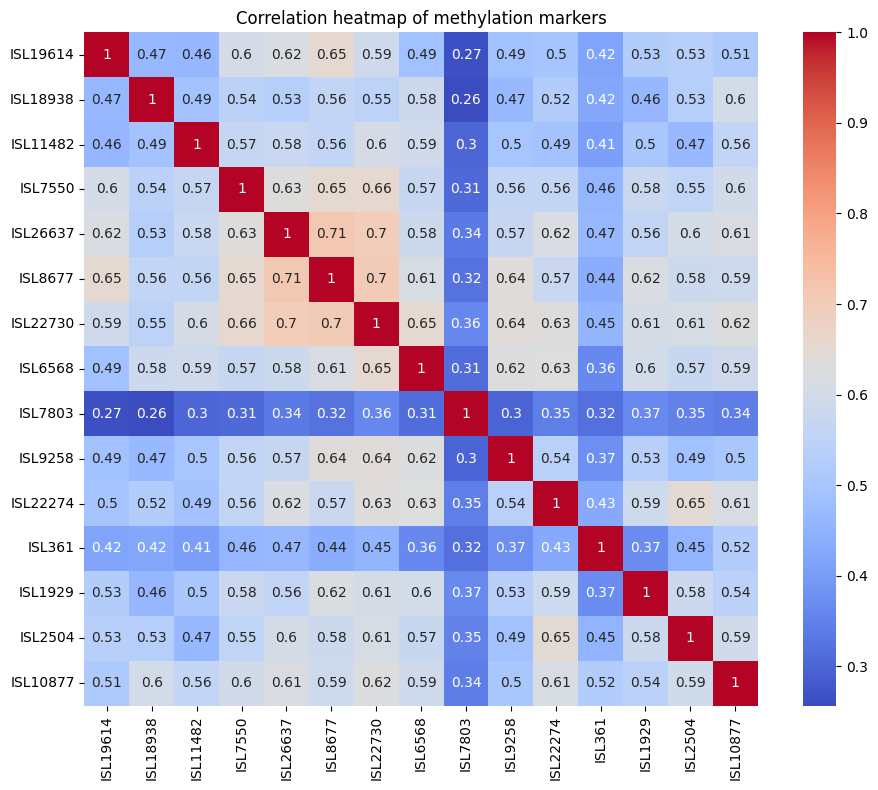

In [53]:
# Extract the numerical features starting with 'ISL'
numerical_features = [col for col in bladder_data.columns if col.startswith('ISL')]

# Create a correlation matrix
correlation_matrix = bladder_data[numerical_features].corr()

# Generate the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

# Customize the plot
plt.title('Correlation heatmap of methylation markers')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

### PCA to see if the two groups can be separated by the features and to what extent.
#### This will give an idea whether a model will be successful in separation 

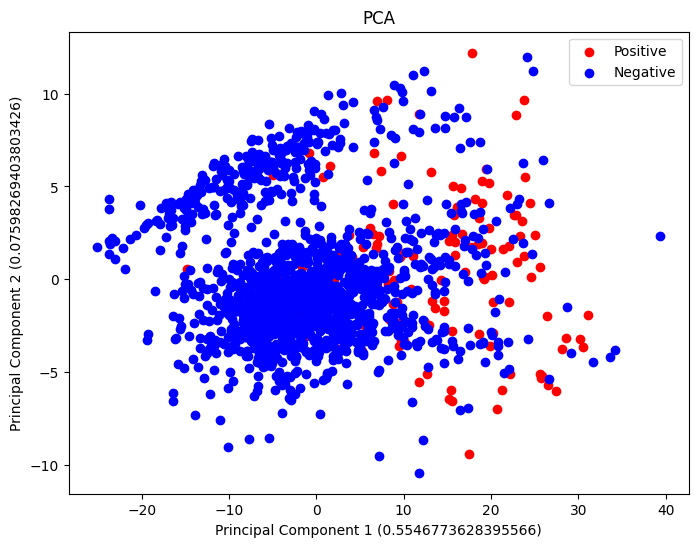

In [171]:
# Extract the feature columns
feature_columns = [col for col in bladder_data.columns if col.startswith('ISL')]

# Extract the feature data
X = bladder_data[feature_columns].values

labels = bladder_data['Gold Standard']

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
# Calculate the variance explained by PC1 and PC2
variance_explained_pc1 = explained_variance_ratio[0]
variance_explained_pc2 = explained_variance_ratio[1]

# Plot the PCA results
plt.figure(figsize=(8, 6))
# Prepare a list of colors for each label
label_colors = {'Positive': 'red', 'Negative': 'blue'}  

# Get the labels from the DataFrame column
labels = bladder_data['Gold Standard']

# Create a scatter plot with different colors for each label
for label in set(labels):
    indices = labels == label
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=label_colors[label], label=label)

plt.xlabel(f"Principal Component 1 ({variance_explained_pc1})")
plt.ylabel(f"Principal Component 2 ({variance_explained_pc2})")
plt.title("PCA")
plt.legend()
plt.show()

# note: data seem to be hard to separate on a 2d visualization.

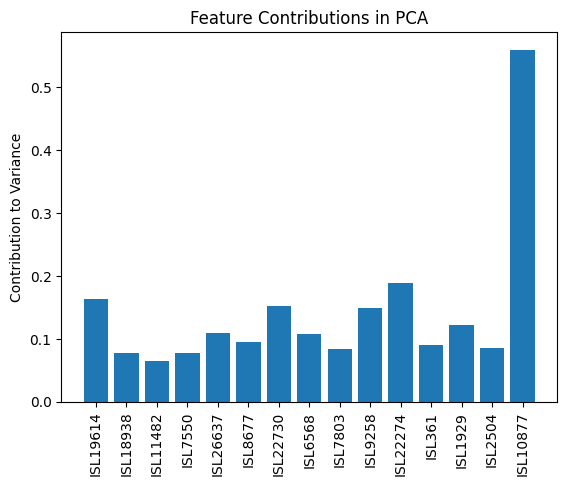

In [134]:
# Get the principal components (eigenvectors)
components = pca.components_

# Calculate the absolute contribution of each feature to the variance
feature_contributions = np.abs(components.T) * explained_variance_ratio[:, np.newaxis]

# Create a bar plot to visualize the feature contributions
fig, ax = plt.subplots()
feature_names = feature_columns 
x = np.arange(len(feature_names))
ax.bar(x, feature_contributions.sum(axis=0))
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=90)
ax.set_ylabel('Contribution to Variance')
ax.set_title('Feature Contributions in PCA')
plt.show()

### Create a model to predict positive/negative outcome by the methylation markers

#### Linear model - logistic regression

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


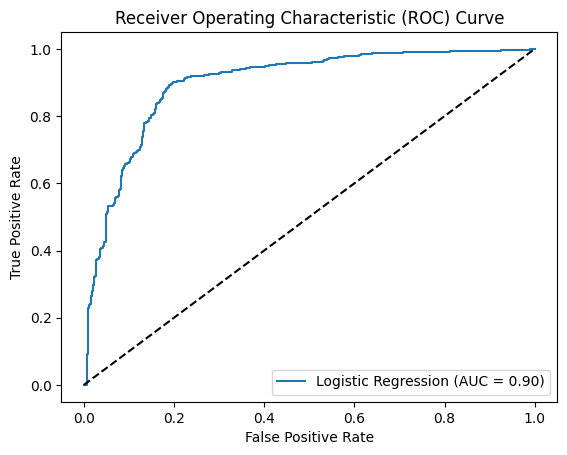

Confusion Matrix:
[[373  79]
 [ 58 386]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.84       452
           1       0.83      0.87      0.85       444

    accuracy                           0.85       896
   macro avg       0.85      0.85      0.85       896
weighted avg       0.85      0.85      0.85       896



In [155]:
# Extract the feature columns starting with 'ISL'
feature_columns = [col for col in bladder_data.columns if col.startswith('ISL')]

# Addressing class imbalance
X = bladder_data[feature_columns]
y = bladder_data['Gold Standard']

# Convert string labels to binary values
y = y.map({'Negative': 0, 'Positive': 1})

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Perform feature scaling on both the training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test_scaled)

# Predict probabilities for the positive class
logreg_probs = logreg.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds for ROC curve
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)

# Calculate the AUC for ROC curve
logreg_auc = auc(logreg_fpr, logreg_tpr)

# Plot the ROC curves
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Reference line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Try lowering the threshold to capture more negatives and reduce type 2 error
# y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities of positive class
# custom_threshold = 0.3  # Adjust the threshold as desired
# y_pred_custom = (y_pred_proba >= custom_threshold).astype(str)  # Convert predictions to strings
# label_mapping = {'False': 'Negative', 'True': 'Positive'}
# y_pred_custom = pd.Series(y_pred_custom).map(label_mapping)

# # Evaluate the model
# confusion_mat = confusion_matrix(y_test, y_pred_custom)
# classification_rep = classification_report(y_test, y_pred_custom)


# note: in the default threshold of 0.5 there were many false negatives from the Positive group (type 2 error)
# playing with the threshold wasn't successful because it lowered the accuracy in the Negative group 
# as it helped getting higher accuracy in the Positive group. Will try another model type

In [106]:
# Try diferent methods for loss function (penalty) L1, L2
# Extract the feature columns starting with 'ISL'
feature_columns = [col for col in bladder_data.columns if col.startswith('ISL')]

# Addressing class imbalance
X = bladder_data[feature_columns]
y = bladder_data['Gold Standard']

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a list of regularization strengths to experiment with
regularization_strengths = [0.01, 0.1, 1, 10, 100]

# Loop over the regularization strengths
for strength in regularization_strengths:
    # Create a logistic regression model with L1 regularization
    l1_model = LogisticRegression(penalty='l1', C=strength, solver='liblinear')
    l1_model.fit(X_train, y_train)
    l1_predictions = l1_model.predict(X_test)
    l1_accuracy = accuracy_score(y_test, l1_predictions)
    l1_confusion_matrix = confusion_matrix(y_test, l1_predictions)
    
    # Create a logistic regression model with L2 regularization
    l2_model = LogisticRegression(penalty='l2', C=strength, solver='liblinear')
    l2_model.fit(X_train, y_train)
    l2_predictions = l2_model.predict(X_test)
    l2_accuracy = accuracy_score(y_test, l2_predictions)
    l2_confusion_matrix = confusion_matrix(y_test, l2_predictions)
    
    print(f"Regularization strength: {strength}")
    print("L1 Regularization Accuracy:", l1_accuracy)
    print("L1 Regularization Confusion Matrix:")
    print(l1_confusion_matrix)
    print("---")
    print("L2 Regularization Accuracy:", l2_accuracy)
    print("L2 Regularization Confusion Matrix:")
    print(l2_confusion_matrix)
    print("---")

Regularization strength: 0.01
L1 Regularization Accuracy: 0.8107202680067002
L1 Regularization Confusion Matrix:
[[242  66]
 [ 47 242]]
---
L2 Regularization Accuracy: 0.8274706867671692
L2 Regularization Confusion Matrix:
[[247  61]
 [ 42 247]]
---
Regularization strength: 0.1
L1 Regularization Accuracy: 0.8442211055276382
L1 Regularization Confusion Matrix:
[[253  55]
 [ 38 251]]
---
L2 Regularization Accuracy: 0.8391959798994975
L2 Regularization Confusion Matrix:
[[249  59]
 [ 37 252]]
---
Regularization strength: 1
L1 Regularization Accuracy: 0.8509212730318257
L1 Regularization Confusion Matrix:
[[255  53]
 [ 36 253]]
---
L2 Regularization Accuracy: 0.8492462311557789
L2 Regularization Confusion Matrix:
[[254  54]
 [ 36 253]]
---
Regularization strength: 10
L1 Regularization Accuracy: 0.8492462311557789
L1 Regularization Confusion Matrix:
[[255  53]
 [ 37 252]]
---
L2 Regularization Accuracy: 0.8492462311557789
L2 Regularization Confusion Matrix:
[[255  53]
 [ 37 252]]
---
Regula

#### SVM

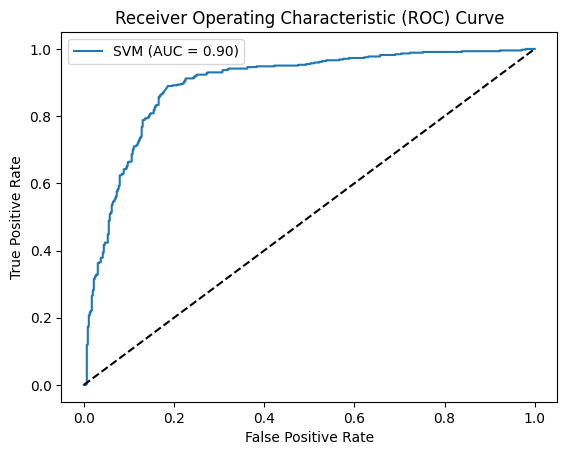

Confusion Matrix:
[[369  83]
 [ 50 394]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       452
           1       0.83      0.89      0.86       444

    accuracy                           0.85       896
   macro avg       0.85      0.85      0.85       896
weighted avg       0.85      0.85      0.85       896



In [153]:
# Extract the feature columns starting with 'ISL'
feature_columns = [col for col in bladder_data.columns if col.startswith('ISL')]

# Addressing class imbalance
X = bladder_data[feature_columns]
y = bladder_data['Gold Standard']

# Convert string labels to binary values
y = y.map({'Negative': 0, 'Positive': 1})

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Create and train the SVM model with linear kernel
svm_model = SVC(kernel='linear', probability=True)  
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
svm_probs = svm_model.predict_proba(X_test)[:, 1]

# Evaluate the model
confusion_mat = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate the false positive rate, true positive rate, and thresholds for ROC curve
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)

# Calculate the AUC for ROC curve
svm_auc = auc(svm_fpr, svm_tpr)

# Plot ROC curve
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Reference line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print the evaluation metrics
print("Confusion Matrix:")
print(confusion_mat)
print("\nClassification Report:")
print(classification_rep)

#### Neural network model

In [157]:
# Extract the feature columns starting with 'ISL'
feature_columns = [col for col in bladder_data.columns if col.startswith('ISL')]

# Extract the label column
label_column = "Gold Standard"

# Split the data into features and labels
X = bladder_data[feature_columns].values
y = bladder_data[label_column].values

# Perform label encoding on the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a sequential model
model = Sequential()

# Add the input layer and the first hidden layer
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))

# Add additional hidden layers
model.add(Dense(32, activation='relu'))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the testing data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



Epoch 1/8
36/36 [==============================] - 1s 13ms/step - loss: 0.2533 - accuracy: 0.9197 - val_loss: 0.2116 - val_accuracy: 0.9136
Epoch 2/8
36/36 [==============================] - 0s 3ms/step - loss: 0.2036 - accuracy: 0.9223 - val_loss: 0.2083 - val_accuracy: 0.9156
Epoch 3/8
36/36 [==============================] - 0s 3ms/step - loss: 0.1955 - accuracy: 0.9232 - val_loss: 0.2145 - val_accuracy: 0.9095
Epoch 4/8
36/36 [==============================] - 0s 3ms/step - loss: 0.1912 - accuracy: 0.9250 - val_loss: 0.2079 - val_accuracy: 0.9115
Epoch 5/8
36/36 [==============================] - 0s 3ms/step - loss: 0.1872 - accuracy: 0.9267 - val_loss: 0.2016 - val_accuracy: 0.9177
Epoch 6/8
36/36 [==============================] - 0s 3ms/step - loss: 0.1821 - accuracy: 0.9276 - val_loss: 0.2191 - val_accuracy: 0.9177
Epoch 7/8
36/36 [==============================] - 0s 3ms/step - loss: 0.1848 - accuracy: 0.9276 - val_loss: 0.1951 - val_accuracy: 0.9156
Epoch 8/8
16/16 [=========

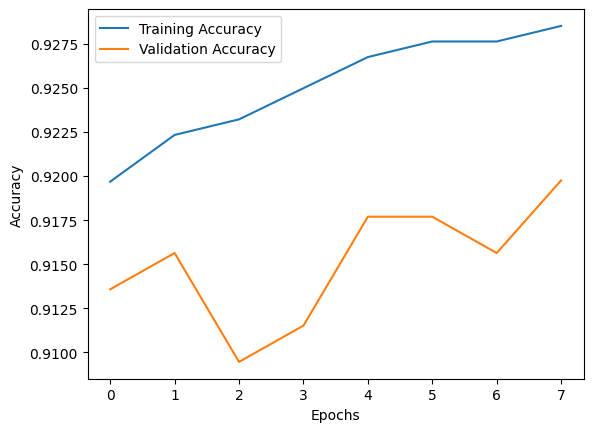

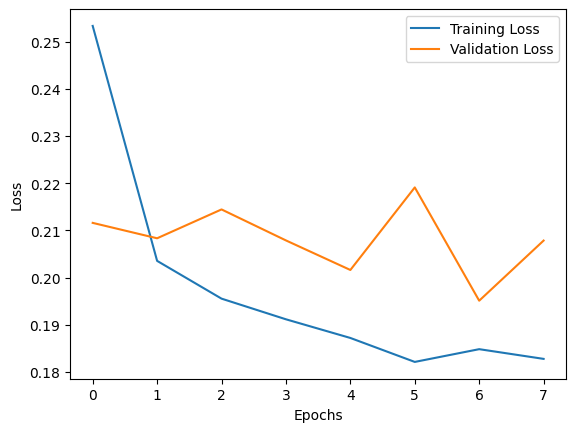

In [161]:
# Access the training accuracy and loss history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

# Access the validation accuracy and loss history
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy over epochs
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss over epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


16/16 [==============================] - 0s 2ms/step


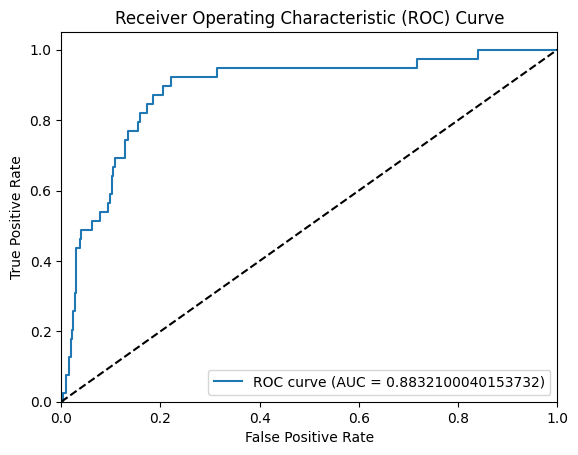

Optimal Threshold: 0.12187035
Confusion Matrix:
[[348  99]
 [  3  36]]


In [159]:
# Make predictions on the testing data
y_pred_prob = model.predict(X_test)

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Choose a threshold based on the ROC curve
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

# Convert the predicted probabilities to binary labels using the optimal threshold
y_pred = np.where(y_pred_prob >= optimal_threshold, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

#### Plot all corves together:

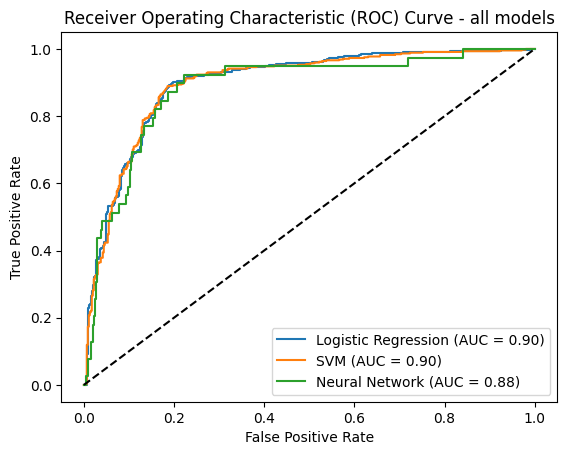

In [169]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot ROC curve for each model
ax.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_auc:.2f})')
ax.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
ax.plot(fpr, tpr, label=f'Neural Network (AUC = {roc_auc:.2f})')

# Plot the reference line for random classifier
ax.plot([0, 1], [0, 1], 'k--')

# Set the x-axis and y-axis labels
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Set the title and legend
ax.set_title('Receiver Operating Characteristic (ROC) Curve - all models')
ax.legend()

# Display the plot
plt.show()
